# Figure 1 - Modularity Paper

Here we hope to show the simplest feedforward version of the requirements for modularisation. Some are for the appendix.

- The one point that needs to be added to modularise, via two simulations.
- Another 2D example that shows the same thing.
- Some correlated variable examples
- Some range assymetric examples

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
import math
import optax
import scipy
from mpl_toolkits.mplot3d import Axes3D
import os
import datetime

1 0.4473506473629427
0.0


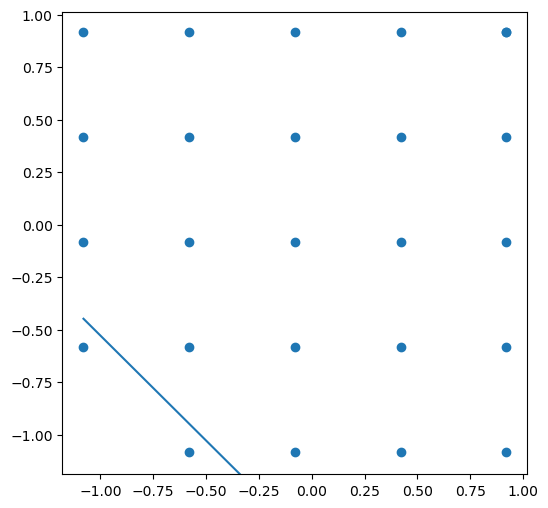

In [26]:
# Setup some parameters
step = 0.5 # Step size between points
v = 1 # What gradient of line do you want to remove from 
Delta = 0 # What shift to that line do you want
H = 10 # How many neurons in representation
act_reg = 2 # Do you use L1 (= 1) or L2?

x, y = np.meshgrid(np.arange(-1, 1+0.0001, step), np.arange(-1, 1+0.0001, step))
points = np.stack([np.ndarray.flatten(x), np.ndarray.flatten(y)])
points_raw = np.copy(points)

# Equation of line is y = -1/v x + x_min/v + Delta
movers = points[1,:] < -1/v * points[0,:] - 1/v - Delta -0.5
points[:,movers] = points[:,movers]*(-1)


plt.figure(figsize = (6, 6))
point_demeaned = points - np.mean(points, axis = 1)[:,None]
plt.scatter(point_demeaned[0,:], point_demeaned[1,:])

covar = np.mean(points[0,:]*points[1,:])

b_x = -np.min(point_demeaned[0,:])
b_y = -np.min(point_demeaned[1,:])

x_plot = np.linspace(np.min(point_demeaned[0,:]), np.max(point_demeaned[0,:]), 100)

vs = [1]#[0.05, 0.1, 0.3, 0.5, 1]
for v_chosen in vs:
    Delta_plot = -b_x + np.sqrt(b_x**2 + (v_chosen**2*b_y**2 + v_chosen*covar))
    #Delta_plot = -b_x+np.sqrt(b_x**2 + v_chosen**2*b_y**2)
    print(v_chosen, Delta_plot)
    y_plot = -1/v_chosen *x_plot  -b_x/v_chosen - Delta_plot/v_chosen
    
    plt.plot(x_plot, y_plot)
    plt.ylim([-b_y*1.1, np.max(point_demeaned[1,:])*1.1])

cov= np.dot(points[0,:], points[1,:])

print(cov)

In [8]:
# Setup some saving things
date = datetime.datetime.now()
today = date.strftime('%Y%m%d')
now = date.strftime('%H:%M:%S')
random_seed = np.random.choice(1000000)

# Make sure folder is there
if not os.path.isdir(f"./data/"):
    os.mkdir(f"./data/")
if not os.path.isdir(f"data/{today}/"):
    os.mkdir(f"data/{today}/")
# Now make a folder in there for this run
savepath = f"data/{today}/{now}_{random_seed}/"
if not os.path.isdir(f"data/{today}/{now}_{random_seed}"):
    os.mkdir(f"data/{today}/{now}_{random_seed}")

In [9]:
I = np.random.normal(0,1, [H,3])
points_bias = np.vstack([points, np.ones([1,points.shape[1]])])

@jit
def generate_rep(I, inputs):
    g = jnn.relu(I@inputs)
    #g = I@inputs
    g_bias = jnp.vstack([g, jnp.ones(g.shape[1])[None,:]])
    return g_bias

@jit
def loss_weight_I(I):
    return jnp.sum(jnp.power(I[:,:-1],2))

@jit
def generate_R(g, outputs):
    mat0 = jnp.matmul(g, g.T)
    mat1 = jnp.matmul(g, outputs.T)
    mat2 = jnp.matmul(jnp.linalg.inv(mat0 + 0.01*jnp.eye(H+1)), mat1)
    return mat2

@jit
def loss_fit(g, R, outputs):
    preds = R.T@g
    return jnp.linalg.norm(outputs - preds) 

@jit
def loss_R(R):
    R_sub = R[:-1,:]
    return jnp.sum(jnp.power(R_sub, 2))

if act_reg == 2:
    @jit
    def loss_act(g):
        return jnp.sum(jnp.power(g[:-1,:], 2))
else:
    @jit
    def loss_act(g):
        return jnp.sum(jnp.abs(g[:-1,:]))

@jit
def loss_pos(g):
    g_neg = (g - jnp.abs(g))/2
    L_pos = -jnp.sum(g_neg)
    return L_pos    

# Loss function parameters
mu_fit = 1000000
mu_G = 1
mu_R = 1
mu_I = 1
mu_pos = 10000
fit_thresh = 0.01


@jit
def loss(params, inputs, outputs):
    g = generate_rep(params["I"], inputs)
    R = generate_R(g, points)

    return mu_fit*jnn.relu(loss_fit(g, R, outputs)-fit_thresh) + mu_G*loss_act(g) + mu_I*loss_weight_I(params["I"]) + mu_R*loss_weight_I(R) + mu_pos*loss_pos(g)
    
@jit
def update(params, inputs, outputs, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, inputs, outputs)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

# Simulation parameters
learning_rate = 1e-5

re_init = 1
if re_init:
    key = random.PRNGKey(random_seed)
    I = random.normal(key, (H, 3))*0.001
    I = I.at[:,-1].set(2)
    optimizer = optax.adam(learning_rate)
    # Obtain the `opt_state` that contains statistics for the optimizer.
    params = {'I': I}
    opt_state = optimizer.init(params)
print(loss(params, points_bias, points))
min_loss = np.infty

config_dict = {'mu_fit':mu_fit, 'mu_G':mu_G, 'mu_R':mu_R, 'mu_I':mu_I, 'mu_pos':mu_pos, 'fit_thresh':fit_thresh, 'learning_rate':learning_rate, 'step':step,
                 'v':v, 'Delta':Delta, 'H':H, 'act_reg':act_reg}
np.save(f"data/{today}/{now}_{random_seed}/config_dict", config_dict)

5603327.0


In [10]:
# Optimisation, run and re-run until it stops hitting new records
T = 10000000
print_iter = 10000

for t in range(T):
    params, opt_state, loss = update(params, points_bias, points, opt_state)

    if t % print_iter == 0:
        g = generate_rep(params["I"], points_bias)
        R = generate_R(g, points)

        L_f = loss_fit(g, R, points)
        L_a = loss_act(g)
        L_R = loss_weight_I(R)
        L_I = loss_weight_I(params["I"])    
        L_p = loss_pos(g)
        print(f"Step {t}, Loss: {loss:.5f}, Fit: {L_f:.5f}, Act: {L_a:.5f}, R: {L_R:.5f}, I: {L_I:.5f}, pos: {L_p:.5f}")
        #print(f"Step {t}, Loss: {loss:.5f}")#, Fit: {L_f:.5f}, Act: {L_a:.5f}, Wei: {L_w:.5f}, R: {L_R:.5f}, Pos: {L_p:.5f}, PI: {L_PI:.5f}")

        min_this_step = 0

    if loss < min_loss:
        params_best = params
        min_loss = loss
        if min_this_step == 0:
            print(f'New min! {loss}')
            min_this_step = 1

Step 0, Loss: 5603327.00000, Fit: 5.61016, Act: 1439.90076, R: 34.18755, I: 0.00003, pos: -0.00000
New min! 5603327.0
Step 10000, Loss: 123536.80469, Fit: 0.13186, Act: 1432.91211, R: 35.84177, I: 0.05675, pos: -0.00000
New min! 122997.953125
Step 20000, Loss: 17751.40234, Fit: 0.02626, Act: 1423.33472, R: 7.23678, I: 0.28890, pos: -0.00000
New min! 17526.701171875
Step 30000, Loss: 1463.62000, Fit: 0.00998, Act: 1411.17200, R: 2.68002, I: 0.78024, pos: -0.00000
New min! 1414.63232421875
Step 40000, Loss: 1342.89417, Fit: 0.00928, Act: 1339.54712, R: 2.49425, I: 0.84242, pos: -0.00000
New min! 1342.8941650390625
Step 50000, Loss: 1215.27698, Fit: 0.00908, Act: 1211.89038, R: 2.50527, I: 0.87003, pos: -0.00000
New min! 1215.2769775390625
Step 60000, Loss: 1094.47021, Fit: 0.00935, Act: 1091.02710, R: 2.54561, I: 0.88576, pos: -0.00000
New min! 1094.47021484375
Step 70000, Loss: 973.98157, Fit: 0.00963, Act: 970.45056, R: 2.61572, I: 0.90325, pos: -0.00000
New min! 973.9815673828125
Step

KeyboardInterrupt: 

In [11]:
print(min_loss)
np.save(f"data/{today}/{now}_{random_seed}/params_best.npy", params_best)

if True:
    date = '20240507'
    time = '11:07:46_714419'
    
    params_best = np.load(f'./data/{date}/{time}/params_best.npy', allow_pickle=True)[()]

40.997845


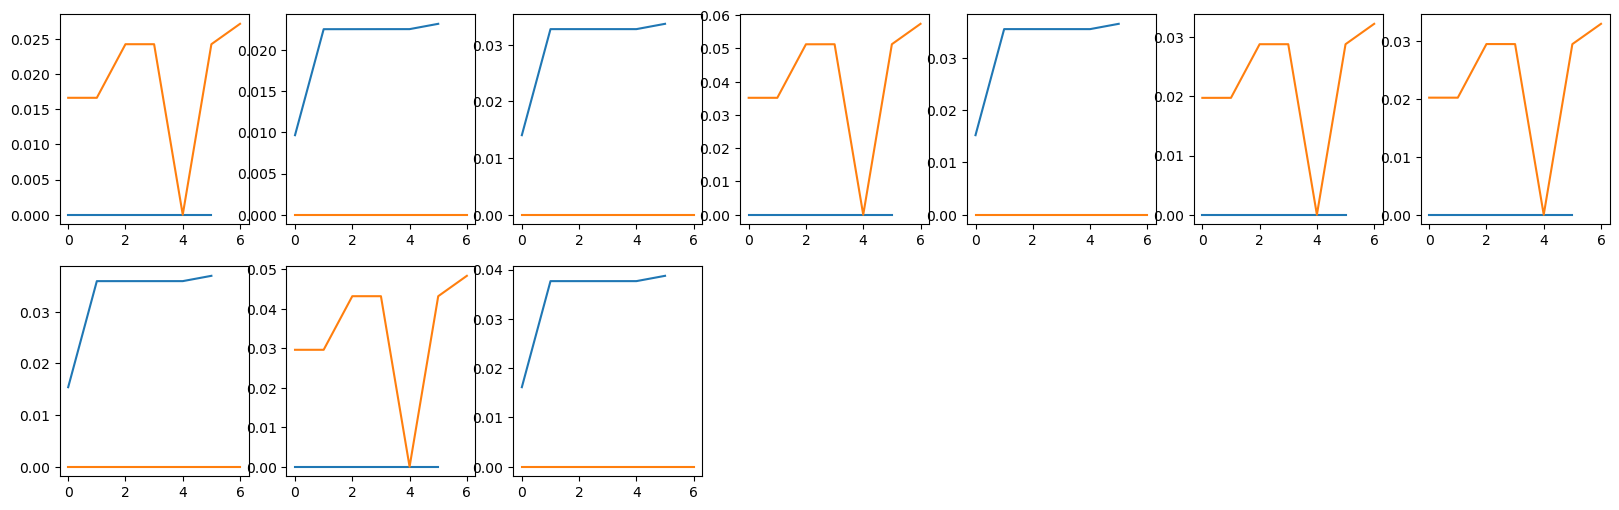

In [12]:
input_currents = jnn.relu(params_best['I']@ points_bias)
max_current = np.max(input_currents)
min_current = np.min(input_currents)

unique_x = np.unique(points[0,:])
unique_y = np.unique(points[1,:])
mean_values_x = np.zeros([H, len(unique_x)])
mean_values_y = np.zeros([H, len(unique_y)])
for val_ind, val in enumerate(unique_x):
    mean_values_x[:,val_ind] = np.var(input_currents[:,points[0,:] == val], axis = 1)
for val_ind, val in enumerate(unique_y):
    mean_values_y[:,val_ind] = np.var(input_currents[:,points[1,:] == val], axis = 1)

min_mean = np.min([np.min(mean_values_x), np.min(mean_values_y)])
max_mean = np.max([np.max(mean_values_x), np.max(mean_values_y)])

rows = 2
plt.figure(figsize = (20, 3*rows))

for neuron in range(H):
    plt.subplot(rows,int(H/rows)+2,neuron+1)
    plt.plot(mean_values_x[neuron,:])
    plt.plot(mean_values_y[neuron,:])
    #plt.ylim([min_mean, max_mean])

var_matrix = np.stack([np.mean(mean_values_x, axis = 1), np.mean(mean_values_y, axis = 1)])

Info_M: 19.00000
Proportion of Variance: 1.00000


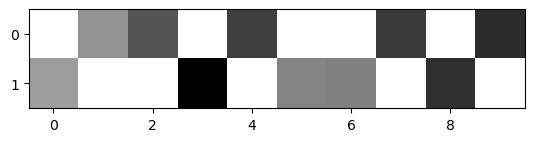

In [13]:
plt.imshow(var_matrix, cmap = 'Grays')

Info_M = (np.sum(np.max(var_matrix, axis = 0)/np.sum(var_matrix, axis = 0)) - 1/2)/(1-1/2)
print(f'Info_M: {Info_M:.5f}')

prop_var = (np.sum(np.max(var_matrix, axis = 0))/np.sum(var_matrix) - 1/2)/(1-1/2)
print(f'Proportion of Variance: {prop_var:.5f}')

In [14]:
np.argmax(np.min(var_matrix, axis = 0))

3

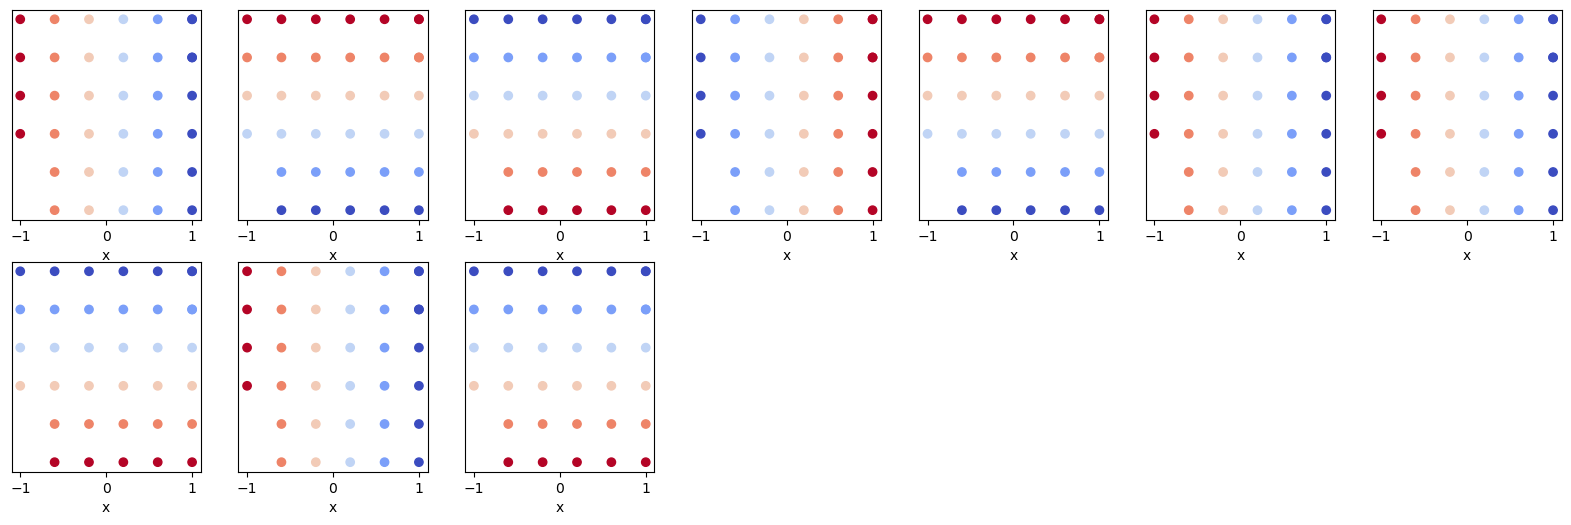

In [15]:
rows = 2
plt.figure(figsize = (20, 3*rows))

for neuron in range(H):
    plt.subplot(rows,int(H/rows)+2,neuron+1)
    plt.scatter(points[0,:], points[1,:], c = input_currents[neuron,:], cmap='coolwarm')
    #plt.ylim([min_current, max_current])
    plt.xlabel('x')

    #if neuron%5 != 0:
    plt.yticks([])
plt.show()

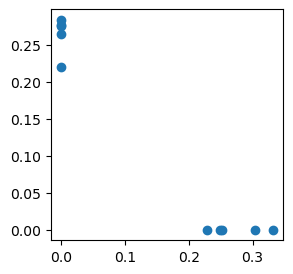

In [16]:
I = params_best['I'][:,:2]
plt.figure(figsize = (3,3))
plt.scatter(np.abs(I[:,0]), np.abs(I[:,1]))

In [218]:
# TO DO: Code to generate figure

In [18]:
np.save('./data/jin_data.npy', params_best)